In [15]:
import pandas as pd
from src.ads.pipelines.ads_data_science.nodes import preprocess_data
from src.ads.pipelines.utils.utils_analysis import evaluate_performance, postprocess_pred
import matplotlib.pyplot as plt
from sktime.forecasting.arima import AutoARIMA, ARIMA
from src.ads.pipelines.utils.utils_analysis import test_stationarity, split_train_test
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data/01_raw/train.csv")

In [3]:
data = preprocess_data(data)

## Data visualisation

In [4]:
data

,y
date,
2015-01,1.91157
2015-02,1.44733
2015-03,1.89355
2015-04,2.03274
2015-05,2.27843
...,...
2020-10,2.21851
2020-11,2.01204
2020-12,1.97353


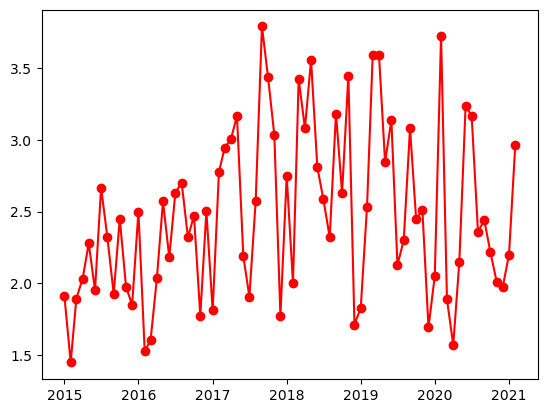

In [5]:
plt.plot(data.index.to_timestamp(how='start'), data["y"], marker='o', linestyle='-',color="red")

The data is monthly. We have data from January 2015 to February 2021. 

## Stationarity test

A **stationary series** is a time series whose statistical properties such as the mean, variance, and covariance remain constant over time. This means that the internal structure of the series, including the statistical dependencies between observations, does not change over time.

The **rolling mean** is a statistical technique used to analyze data series by creating a series of averages from different subsets of the complete dataset.

The **rolling standard deviation** (rolling std) is a statistical measure used to analyze time series data by calculating the standard deviation of data points within a moving window. This technique is used to understand the variability or volatility of the dataset over a specified number of periods.

The data are monthly, so we decide to choose a window of 12.

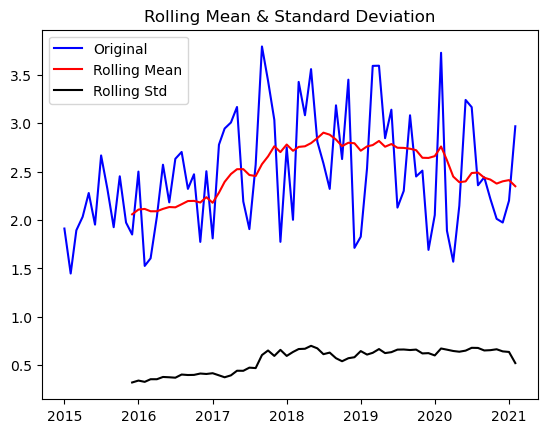

Results of Dickey-Fuller Test:
Test Statistic                -6.156135e+00
p-value                        7.360988e-08
#Lags Used                     0.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64
ADF Statistic: -6.156135
p-value: 0.000000
The data are stationary at 1%
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588


In [6]:
test_stationarity(data, window = 12)

The **Augmented Dickey-Fuller** (ADF) test is a statistical test used to determine whether a given time series is stationary or not. 

Null Hypothesis (H0): The null hypothesis of the ADF test asserts that the time series has a unit root, meaning it is non-stationary. 

Alternative Hypothesis (H1): The alternative hypothesis suggests that the time series is stationary, which means no unit root is present.

The **ADF** test statistic is -6.156135. This value is far more negative than the critical values for 1%, 5%, and 10% significance levels. We compare the ADF test statistic against the critical values. The test statistic is more negative than the critical values, so it suggests that the null hypothesis can be rejected, we conclude that the time serie is stationary.

The **ARMA** model is used for stationary series because it is based on the assumption that the statistical properties of the series (such as the mean and variance) remain constant over time.

The ARMA model consists of two parts:
- **AR** (AutoRegressive) part: A autoregressive model that captures the linear dependence between past observations and the current observation. It includes the autoregressive terms, where the current time series. p is the number of autoregressive terms.
- **MA** (Moving Average) part: A moving average model with parameter q uses the q forecast errors (the deviations between observed values and predicted values) from past forecasts to influence the current forecast.

## ACF

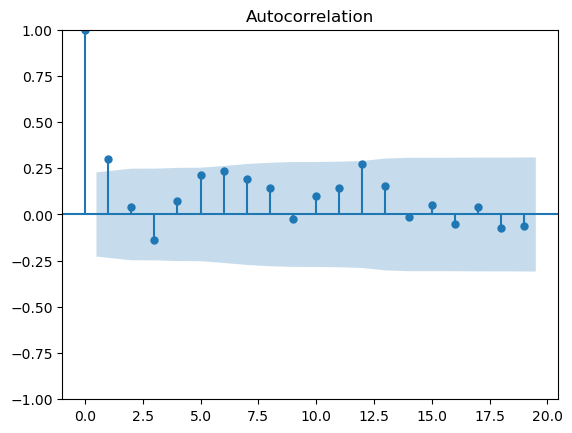

In [7]:
plot_acf(data)
plt.show()
plt.close() 


The **Autocorrelation Function** (ACF) measures the autocorrelation of a time series with itself at different lags. The autocorrelation is significant only at the first lag (lag 1), and the values for subsequent lags quickly fall towards zero or into the zone of insignificance. This indicates that only the first lag has a significant influence. This suggests that a single moving average term (q = 1) might be sufficient to capture the majority of the autocorrelations in the series, thus justifying the choice of q = 1 for the ARMA model.

## PACF

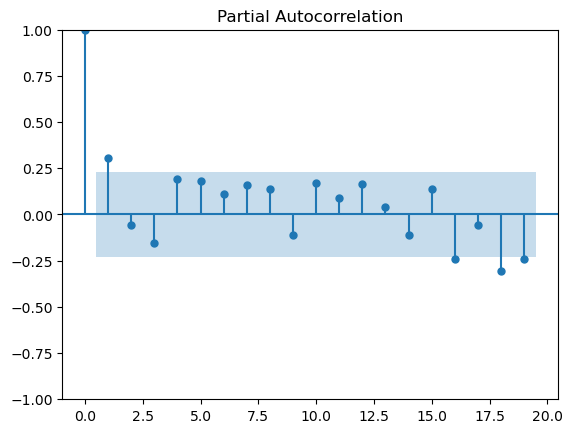

In [8]:
plot_pacf(data)
plt.show()
plt.close()  

The **Partial Autocorrelation Function** (PACF) measures the autocorrelation between a time series and its lags, eliminating the effects of intermediate lags. We observe that the partial correlation is significant only at the first lag (lag 1), and the values for higher lags drop quickly and fall into the insignificance zone, indicating that only the first lag has a significant direct influence. This justifies the choice of p=1 for the ARMA model.

### Split train test

In [9]:
data_train, data_test = split_train_test(data, split_ratio = 0.2)

### ARMA

In [10]:
# training ARMA(p,q)
p = 1
q = 1
model_arma = ARIMA(order=(p, 0, q))
fitted_model_arma = model_arma.fit(data_train["y"]) 

In [11]:
fitted_model_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -47.697
Date:                Mon, 29 Apr 2024   AIC                            103.395
Time:                        02:38:53   BIC                            111.705
Sample:                    01-31-2015   HQIC                           106.639
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3926      0.857      1.626      0.104      -0.287       3.072
ar.L1          0.4411      0.342      1.290      0.197      -0.229       1.111
ma.L1         -0.0880      0.360     -0.244      0.807      -0.794       0.618
sigma2         0.2942      0.065      4.510      0.000       0.166       0.422
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.96   Prob(JB):                         0.63
Heteroskedasticity (H):               1.76   Skew:                             0.20
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The **AIC** of the model is 103.395.

In [16]:
# test and evaluation
y_test_pred = fitted_model_arma.predict(fh=np.arange(1, len(data_test) + 1)) 
data_test_pred = postprocess_pred(y_test_pred)
metrics_arma = evaluate_performance(data_test,data_test_pred) 

In [17]:
metrics_arma

{'mse': 0.375, 'mae': 0.533, 'rmse': 0.612, 'mape': 0.235}

In the following graph, we see the predicted values and the actual values : 

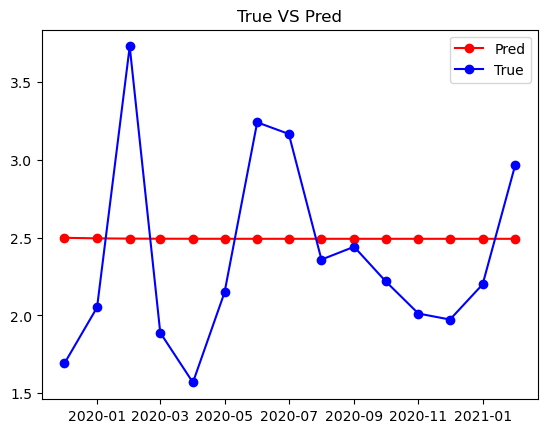

In [18]:
plt.plot(data_test_pred.index.to_timestamp(how='start'), data_test_pred["y"], marker='o', linestyle='-',color="red",label='Pred')
plt.plot(data_test.index.to_timestamp(how='start'), data_test["y"], marker='o', linestyle='-',color="blue",label='True')
plt.legend(loc='best')
plt.title('True VS Pred')
plt.show(block=False)

### Auto_ARIMA

**ARIMA** is an extension of ARMA designed to deal with non-stationary series by incorporating a differentiation step (parameter d).

It is often difficult to determine the exact parameters of a model graphically. We can use the AutoARIMA function, which automates the process of selecting the orders p, d, q.

This function can perform stationarity tests and determine the differentiation term d if necessary.

It also includes the ability to model seasonality by adding seasonal terms to the model (**SARIMA**).

 To determine the optimal parameters, the algorithm uses AIC.

In [19]:
stationary = False # automatic test
test = "adf" # test to use for stationarity
sp = 12 # monthly data, yearly seasonality

In [20]:
model_arima = AutoARIMA(stationary=stationary,test=test,sp = 12, trace=True,suppress_warnings=True)
fitted_model_arima = model_arima.fit(data_train["y"]) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=107.851, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=99.185, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=100.944, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=280.633, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=101.515, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=101.176, Time=0.71 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=99.641, Time=0.19 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=102.925, Time=1.72 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=101.669, Time=0.55 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=100.352, Time=0.76 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=100.812, Time=0.81 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=100.515, Time=0.50 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=

In [21]:
fitted_model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   59
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -45.593
Date:                            Mon, 29 Apr 2024   AIC                             99.185
Time:                                    02:41:27   BIC                            107.496
Sample:                                01-31-2015   HQIC                           102.429
                                     - 11-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2239      0.317      3.861      0.000       0.603       1.845
ar.L1          0.2855      0.129      2.212      0.027       0.033       0.538
ar.S.L12       0.3063      0.135      2.274      0.023       0.042       0.570
sigma2         0.2688      0.064      4.193      0.000       0.143       0.394
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.76   Prob(JB):                         0.42
Heteroskedasticity (H):               1.54   Skew:                             0.22
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The **AIC** of the model is 99.185.

In [23]:
# test and evaluation
y_test_pred = fitted_model_arima.predict(fh=np.arange(1, len(data_test) + 1)) 
data_test_pred = postprocess_pred(y_test_pred)
metrics_arima = evaluate_performance(data_test,data_test_pred) 

In [24]:
metrics_arima

{'mse': 0.409, 'mae': 0.531, 'rmse': 0.639, 'mape': 0.236}

In the following graph, we see the predicted values and the actual values : 

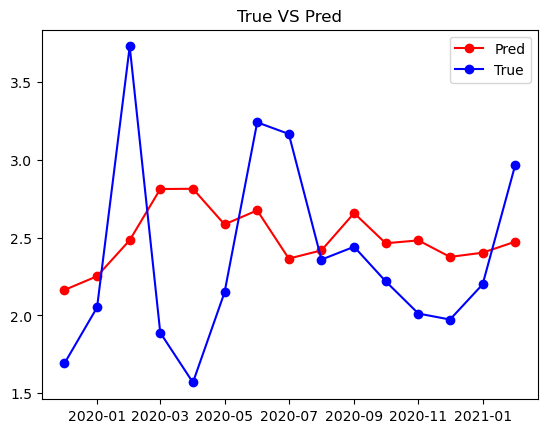

In [25]:
plt.plot(data_test_pred.index.to_timestamp(how='start'), data_test_pred["y"], marker='o', linestyle='-',color="red",label='Pred')
plt.plot(data_test.index.to_timestamp(how='start'), data_test["y"], marker='o', linestyle='-',color="blue",label='True')
plt.legend(loc='best')
plt.title('True VS Pred')
plt.show(block=False)

### Comparison Auto_ARIMA and ARMA

The : 
- MSE (Mean Squared Error)
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)

are calculated

In [26]:
metrics_arma

{'mse': 0.375, 'mae': 0.533, 'rmse': 0.612, 'mape': 0.235}

In [27]:
metrics_arima

{'mse': 0.409, 'mae': 0.531, 'rmse': 0.639, 'mape': 0.236}

The errors of the models are close.
- MSE (Mean Squared Error): The ARMA model has a lower MSE (0.375) compared to the ARIMA model (0.409)
- MAE (Mean Absolute Error): The ARMA model has a lower MAE (0.533) compared to the ARIMA model (0.513)
- RMSE (Root Mean Squared Error): The ARMA model has a lower RMSE (0.612) compared to the ARIMA model (0.639)
- MAPE (Mean Absolute Percentage Error): The ARMA model has a slightly higher MAPE (0.235) compared to the ARIMA model (0.236)

The AIC quantifies the goodness of fit of a model along with the complexity of the model. 

The AIC of ARIMA (99.185) is lower than the AIC of ARMA (103.395).

We decide to use ARIMA model for the training pipeline.